In [24]:
# 2017-02-01

In [2]:
# 1.1 Import tensorflow and other libraries.

import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab

/Users/masato/duolingo/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


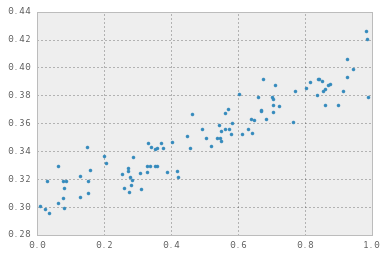

In [3]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_data = np.random.rand(100).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_data))
y_data = x_data * 0.1 + 0.3 + noise

# Uncomment the following line to plot our input data.
pylab.plot(x_data, y_data, '.')


In [4]:
# 1.3 Buld inference graph.
W = tf.Variable(tf.random_uniform([1], 0.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

In [5]:
# 1.4 Build training graph.
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(.5)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [6]:
# 1.6 Create a session and launch the graph.
sess = tf.Session()
sess.run(init)
y_initial_values = sess.run(y)

In [7]:
# 1.7 Perform training.
for step in xrange(201):
    sess.run(train)

print(sess.run([W, b]))

[array([ 0.10062937], dtype=float32), array([ 0.30088043], dtype=float32)]


(0, 1.0)

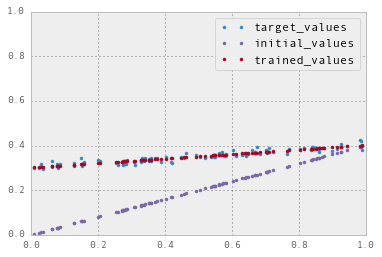

In [8]:
# 1.8 Uncomment the following lines to compare.
pylab.plot(x_data, y_data, '.', label="target_values")
pylab.plot(x_data, y_initial_values, ".", label="initial_values")
pylab.plot(x_data, sess.run(y), ".", label="trained_values")
pylab.legend()
pylab.ylim(0, 1.0)


In [9]:
# 2017-02-02

In [10]:
import math
import os
from six.moves import xrange
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
NUM_CLASSES = 10
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

MAX_STEPS = 2000

TRAIN_DIR = '/Users/masato/dev/mnist'

In [12]:
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting /Users/masato/dev/mnist/train-images-idx3-ubyte.gz
Extracting /Users/masato/dev/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/masato/dev/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/masato/dev/mnist/t10k-labels-idx1-ubyte.gz


In [13]:
data_sets

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1154aead0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1154ae190>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1154ae4d0>)

In [27]:
def mnist_inference(images, hidden1_units, hidden2_units):
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                                stddev = 1.0 / math.sqrt(float(IMAGE_PIXELS))),
            name='weights')
        
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev = 1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
        
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                stddev = 1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                             name='biases')
        logits = tf.matmul(hidden2, weights) + biases
    
    return logits

In [21]:
def mnist_training(logits, labels, learning_rate):
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_man')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    return train_op, loss

In [28]:
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    images_placeholder = tf.placeholder(tf.float32)
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection('images', images_placeholder)
    tf.add_to_collection('labels', labels_placeholder)
    
    logits = mnist_inference(images_placeholder,
                             HIDDEN1_UNITS, HIDDEN2_UNITS)
    tf.add_to_collection('logits', logits)
    
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)
    
    init = tf.initialize_all_variables()
    
    saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [29]:
with tf.Session(graph=mnist_graph) as sess:
    sess.run(init)
    
    for step in xrange(MAX_STEPS):
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)
        
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={images_placeholder: images_feed,
                                            labels_placeholder: labels_feed})
        if step % 1000 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))
        
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

Step 0: loss = 2.30
Step 1000: loss = 0.56


Ground truth: 2
Prediction: 2


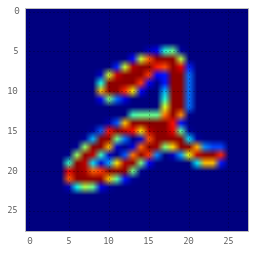

In [36]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, 'checkpoint-1999.meta'))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, 'checkpoint-1999'))
    
    logits = tf.get_collection('logits')[0]
    images_placeholder = tf.get_collection('images')[0]
    labels_placeholder = tf.get_collection('labels')[0]
    
    eval_op = tf.nn.top_k(logits)
    
    images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op,
                         feed_dict={images_placeholder: images_feed,
                                    labels_placeholder: labels_feed})
    print('Ground truth: %d\nPrediction: %d' % (labels_feed, prediction.indices[0][0]))